# <font size="200"> A small showcase of CREST </font>
Thank you to [Jupyter](http://jupyter.org/) and [Binder](https://mybinder.org/) for building the base of interactive CREST.

This is a preliminary implementation. It is meant as a showcase and is not yet production ready.  
The source code can be found here: https://github.com/stklik/CREST/tree/binder

### How to use this Jupyter notebook:  
select a cell (with code) and click the 'Run' button above to execute it.
If there is output, it will be shown directly underneath the cell. 
Remember that the cells can create dependencies

**Alternatively**:  
Menu 'Cell' -> 'Run all'


# First import the necessary libraries

In [1]:
# Recommendation to leave the logging config like this, otherwise you'll be flooded with unnecessary info
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')  

# import all model concepts
from src.model import *

# import the simulator
from src.simulator.simulator import Simulator

# import a library that can visualise our systems
from src.ui import dotter

## Define the resources that we use in the system

In [2]:
# define the resources in a class, so they are bundled. This is syntactic sugar.
# it is important however that none of the resources has the same name as any of the ports!

# currently supported domains: REAL, INTEGER and lists of discrete values
class Resources(object):
    electricity = Resource("Watt", REAL)
    switch = Resource("switch", ["on", "off"])
    light = Resource("Lumen", INTEGER)
    time = Resource("minutes", REAL)
    celsius = Resource("Celsius", REAL)
    fahrenheit = Resource("Fahrenheit", REAL)
    

## Let's define an entity
Entities derive from the basic 'Entity' class.  
They can define:
 - inputs, outputs and local variables
 - states and the current state
 - transitions between states
 - influences between ports (incl. transformations)
 - updates related to a port

In [3]:

# this is a definition of a new Entity type
# it derives from the Entity base class
class LightElement(Entity):
    # we define ports - each has a resource and an initial value
    electricity = Input(resource=Resources.electricity, value=0)
    light = Output(resource=Resources.light, value=0)
    
    # automata states - don't forget to specify one as the current state
    on = State()
    off = current = State()
    
    # transitions and guards (as lambdas)
    off_to_on = Transition(source=off, target=on, guard=(lambda self: self.electricity.value >= 100))
    on_to_off = Transition(source=on, target=off, guard=(lambda self: self.electricity.value < 100))
    
    # update functions are related to a state and define the value of a port
    @update(state=on, target=light)
    def set_light_on(self, dt=0):
        return 800

    @update(state=off, target=light)
    def set_light_off(self, dt=0):
        return 0

## Plotting
We use the *dotter* module to create a graphviz-dot based system representation.

We can pass Boolean-valued options into the function call to adjust the output.  
Options are as follows (incl. default values)
 - updates = True
 - update_labels = False
 - transitions = True
 - transition_labels = False
 - influence_labels = False
 - interface_only = False
 - no_behaviour = False
 - show_update_ports = False
 
 
**GO AHEAD AND TRY IT**

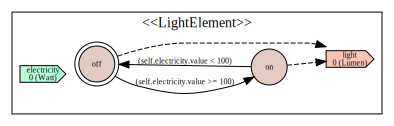

In [4]:
dotter.plot(LightElement(), transition_labels=True)

## Define another entity (without state ??)
Note that this one does not have a state automaton.  
 -- actually we can argue that it does have a state that is always the current state and we just don't show it, but that's semantics)

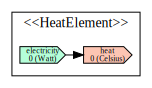

In [5]:
class HeatElement(Entity):
    electricity = Input(resource=Resources.electricity, value=0)
    heat = Output(resource=Resources.celsius, value=0)
        
    # define an influence function
    @influence(source=electricity, target=heat)
    def heat_output(value):
        return value / 100

# show us what it looks like
dotter.plot(HeatElement())
    

# Logical Entities

These entities are just like any other entity.  
We however specify explicitly that they do not have real world counterparts.

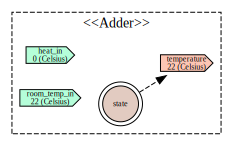

In [6]:
# a logical entity (this one sums two values)
class Adder(LogicalEntity):
    heat_in = Input(resource=Resources.celsius, value=0)
    room_temp_in = Input(resource=Resources.celsius, value=22)
    temperature = Output(resource=Resources.celsius, value=22)
    
    state = current = State()
    @update(state=state, target=temperature)
    def add(self, dt):
        return self.heat_in.value + self.room_temp_in.value
    
dotter.plot(Adder())  # try adding the display option 'show_update_ports=True' and see what happens!

## A more complex entity (incl. subentities)
The GrowLamp is a standard entity just like the ones above, except...  
... it defines subentities !!

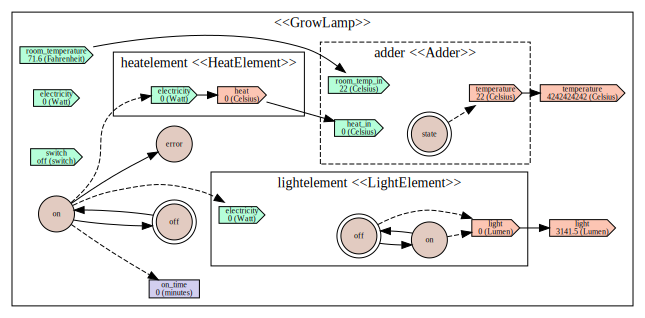

In [7]:
class GrowLamp(Entity):
    # interface
    electricity = Input(resource=Resources.electricity, value=0)
    switch = Input(resource=Resources.switch, value="off")
    room_temperature = Input(resource=Resources.fahrenheit, value=71.6)
    light = Output(resource=Resources.light, value=3.1415*1000) # note that these are bogus values
    temperature = Output(resource=Resources.celsius, value=4242424242) # yes, nonsense...
    
    # states & transitions
    on = State()
    off = current = State()
    error = State()
    
    off_to_on = Transition(source=off, target=on, guard=(lambda self: self.switch.value == "on" and self.electricity.value >= 100))
    on_to_off = Transition(source=on, target=off, guard=(lambda self: self.switch.value == "off" or self.electricity.value < 100))
    on_time = Local(resource=Resources.time, value=0)
    
    
    # transition to error state if the lamp ran for more than 1000.5 time units
    @transition(source=on, target=error)
    def to_error(self):
        return self.on_time.value >= 1000.5
    
    # subentitites are defined HERE !!!
    """ - - - - - - - - - - - - - - - - - """
    lightelement = LightElement()
    heatelement = HeatElement()
    adder = Adder()
    """ - - - - - - - - - - - - - - - - - """
    
    @update(state=on, target="lightelement.electricity")
    def update_light_elec(self, dt):
        return 100
    
    @update(state=on, target="heatelement.electricity")
    def update_heat_elec(self, dt):
        return self.electricity.value - 100
        
    @update(state=on, target=on_time)
    def update_time(self, dt):
        return self.on_time.value + dt
        
    @influence(source=room_temperature, target=adder.room_temp_in)
    def fahrenheit_to_celsius(value):
        return (value - 32) * 5 / 9
    
    # we can also define updates and influences with lambda functions... 
    heat_to_add = Influence(source=heatelement.heat, target=adder.heat_in, function=(lambda val: val))
    
    # if the lambda function doesn't do anything (like the one above) we can omit it...
    add_to_temp = Influence(source=adder.temperature, target=temperature)
    light_to_light = Influence(source=lightelement.light, target=light)

# create an instance!
gl = GrowLamp()
dotter.plot(gl)

## Validate the Model (alpha version)
The validator currently shipped tries to establish the structural validity.
It is not a perfect tool and performs some basic checks. 

It performs the most important checks, but by no means think that your model is completely functional just because the checks pass.
This will become more functional as we go continue.

In [8]:
from src.model.validator import Validator

val = Validator(gl)
val.test()  # 

INFO:Did not find any problem. Beware, this tool does not check everything!


## We are now going to use the Simulator
A simulator is initialized with a root-entity and a time domain.
For convenience we can define which plotter to use too.

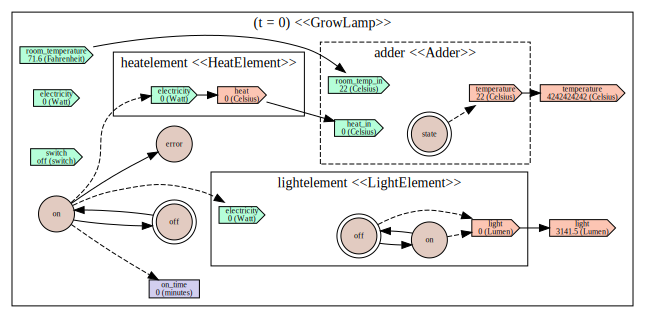

In [9]:
sim = Simulator(gl, timeunit=REAL, plotter=dotter)
sim.plot() # the plotting should be the same as above -- except for the current time, that is!

## Stabilisation
The simulator can run the system until it is stable.  
I.e. until there is a fixpoint, where all influences have been propagated and the updates have written their port values.  
Look specifically at the **output** values, they are now correct !!


*Note: the value of room_temp_in is 21.999999...  This is a result of the calculation: (71.6-32)*5/9  
*It has to do with Python's floating point calculations. 
The next CREST version will use SymPy to symbolically perform calculations and have precise results.*

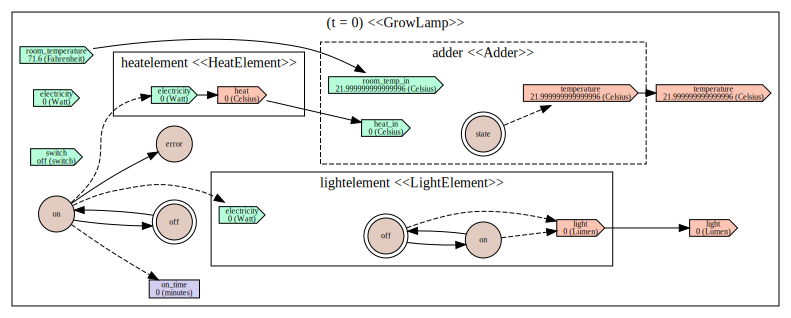

In [10]:
sim.stabilise()
sim.plot()

## Modification of input values

When we modify input port values, we see that nothing happens except what we explicitly changed.  

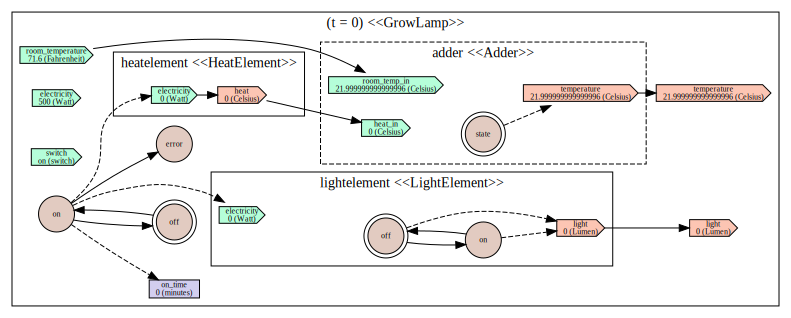

In [11]:
# modify the growlamp instance's inputs directly, the simulator points to that object and will use it
gl.electricity.value = 500
gl.switch.value = "on"
sim.plot()

It actually takes another *stabilisation_fp* to propagate the values

INFO:Firing transition in  (GrowLamp) : off -> on
INFO:Firing transition in lightelement (LightElement) : off -> on


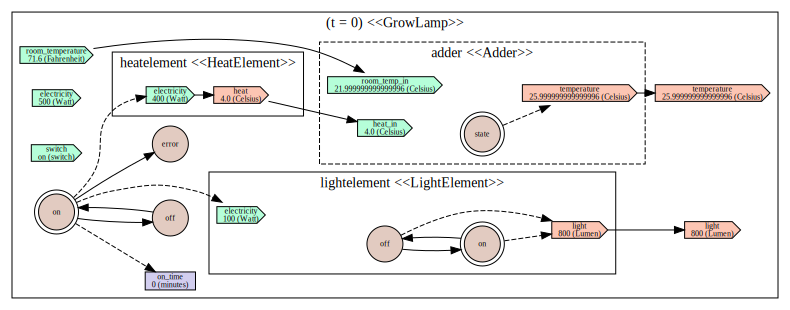

In [12]:
sim.stabilise()
sim.plot()

## Time advance
The *advance(dt)* function can forward time.  
Below we advance 500 time steps. The effect is that the time is now (t=500) and that on_time has the value of 500 too!

INFO:Received instructions to advance 500 time steps
INFO:Advancing 500


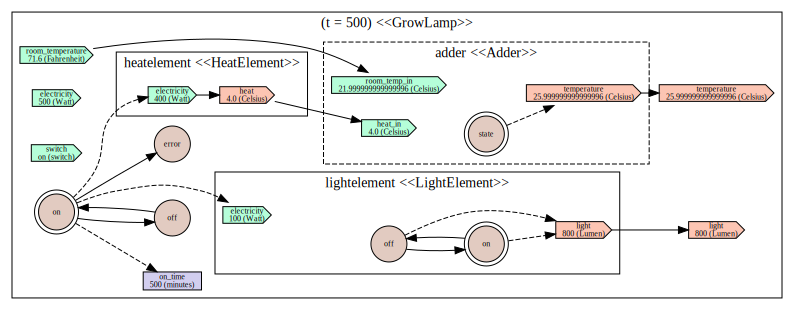

In [13]:
sim.advance(500)
sim.plot()

## Next transition time
The simulation of time advance is based on the calculation of the next transition time.

The simulator can calculate this time by analysing system's updates and influences.  
Currently, only a limited set of features is supported in update/influence functions: variable assignments, arithmetics

*More features (conditional statements & expressions) are being developped but have to be tested first*

The example below states that the error transition will be triggered after 500.5 time steps (i.e. when on_time == 1000.5)

In [14]:
sim.get_next_transition_time()

INFO:The next transition to fire is 'to_error' in ntt=500.5 time steps


## Automatic firing of transitions
Let's assume we want to advance more than the previous 500.5 time steps, what happens then?
Well, we will first advance 500.5 time steps, then fire all transitions, then advance further.

Note, that this function works recursively, so the log output might be a bit confusing...

INFO:Received instructions to advance 550 time steps
INFO:The next transition is in 500.5 time units. Advancing that first, then the rest of the 550.
INFO:Received instructions to advance 500.5 time steps
INFO:Advancing 500.5
INFO:Firing transition in  (GrowLamp) : on -> error
INFO:Now need to advane the rest of the 550: 49.5
INFO:Received instructions to advance 49.5 time steps
INFO:No next transition, just advance 49.5


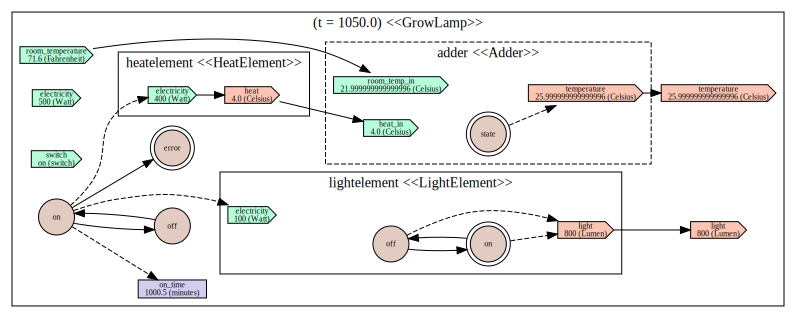

In [15]:
sim.advance(550)
sim.plot()

## Different time scales
By default the simulator will run in real-time.
However, it can be configured to use integers as time unit.
Below we have a simulator that produces two different outputs, depending on the time unit chosen.
Effectively, the system changes to the *error* state when the *on_time* reaches 1000.5 or more.

In **integer** mode the simulator will calculate that a transition happens after **1001** time units, while the **real**-valued simulator will calculate the precise point in time (**1000.5**)


In [16]:
growlamp = GrowLamp()  # create a growlamp instance and change inputs so it should be in state *on*
growlamp.electricity.value = 500
growlamp.switch.value = "on"
simulator = Simulator(growlamp, timeunit=INTEGER, plotter=dotter)
simulator.stabilise()  ## stabilise the system so it's in good state (this will produce output, safely ignore it...)

INFO:Firing transition in  (GrowLamp) : off -> on
INFO:Firing transition in lightelement (LightElement) : off -> on


True

**Now: We will use the same simulator but with different time units to show that the calculations are changed based on this.**

In [17]:
simulator.timeunit = INTEGER
simulator.get_next_transition_time()  # should say 1001 time steps

INFO:The next transition to fire is 'to_error' in ntt=1001 time steps


In [18]:
simulator.timeunit = REAL
simulator.get_next_transition_time()  # should say 1000.5 time steps

INFO:The next transition to fire is 'to_error' in ntt=1000.5 time steps
